In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.stats.multitest as smm
import numpy as np
#from bioinfokit import analys, visuz
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib

color_palette = sns.color_palette("colorblind")

sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

#plt.style.use('../mpl_style_template/poster.mplstyle')

"""matplotlib.rcParams.update({'font.size': 8, 'axes.titlesize': 8, 'axes.labelsize': 8,
                           'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 8,
                            'text.usetex': False, 'svg.fonttype': 'none',
                           'xtick.direction': 'out', 'ytick.direction': 'out',
                            'xtick.bottom': True, 'ytick.left': True,})"""

#matplotlib.rcParams.update({'axes.labelsize': 16,'xtick.labelsize': 16,})
import os


In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 25)
#pd.set_option('display.max_colwidth', 300)
#pd.set_option('format.precision', 2)




In [3]:
# load results table from R DESeq analysis (gene-level, LFC shrinkage)
results_genes=pd.read_csv("shrink_Anno.csv")  
results_genes.rename(columns={"Unnamed: 0": "GENEID"}, inplace = True)


In [5]:
#formatting
data = results_genes
data["padj_rounded"] = data["padj"].map('{:.1e}'.format)
data["GENENAME_padj"] = data["GENENAME"] + "\np=" + data["padj_rounded"].astype(str) +""
data["-log10_padj"] = -np.log10(data["padj"])

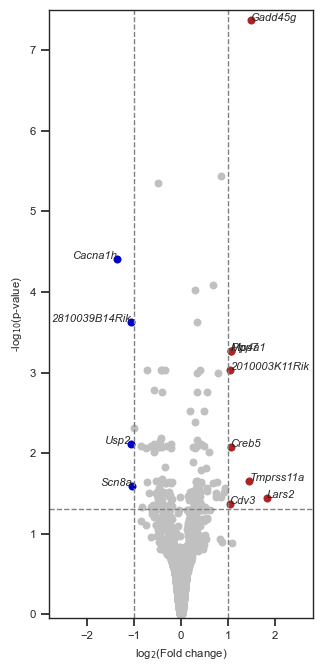

In [7]:
matplotlib.rcParams.update({'font.size': 8.2, 'axes.titlesize': 8.2, 'axes.labelsize': 8.2,
                           'xtick.labelsize': 8.2, 'ytick.labelsize': 8.2, 'legend.fontsize': 8.2,
                            'text.usetex': False, 'svg.fonttype': 'none',
                           'xtick.direction': 'out', 'ytick.direction': 'out',
                            'xtick.bottom': True, 'ytick.left': True, 'axes.linewidth':1})


matplotlib.rcParams.update({'ytick.left': True})
padj_thr = 0.05
lfc_thr = 1

type_list = ["vgic", "lgic", "other_ic", "transporter", "gpcr"]
anno_list = ["Star", "Agtr1a"]
anno_list_3 = [ "Cyp11b2", "Agtr1b", "Agtr2"]
anno_list_2 = ["Cacna1c", "Cacna1d", "Cacna1g"]



#fig, ax = plt.subplots(figsize=(3.4,4))
fig, ax = plt.subplots(figsize=(3.4,7.9))



data_all = data.dropna(subset=["log2FoldChange", "padj", "GENENAME"])
data_all_up = data_all[(data_all["log2FoldChange"] > lfc_thr) & (data_all["padj"] < 0.05)]
data_all_down = data_all[(data_all["log2FoldChange"] < -lfc_thr) & (data_all["padj"] < 0.05)]




ax.scatter(x=data_all["log2FoldChange"],\
            y=data_all["-log10_padj"], color ="silver", s=22, label='not significant')

ax.scatter(x=data_all_up["log2FoldChange"],\
            y=data_all_up["-log10_padj"], color="firebrick", s=22, label='significantly upregulated' )

ax.scatter(x=data_all_down["log2FoldChange"],\
            y=data_all_down["-log10_padj"], color="mediumblue", s=22, label='significantly downregulated' )




ax.set_ylabel("-log10_padj")
ax.set_xlabel("log2FoldChange")





for i in data_all_down["GENENAME"].values:
    gene = data_all_down[data_all_down["GENENAME"] == i]
    y = gene["-log10_padj"].values[0]
    x = gene["log2FoldChange"].values[0]
    
    ax.annotate(gene["GENENAME"].values[0], xy=(x, y), xytext=(x, y), fontsize = 8, 
                    style = "italic", ha="right")

    
for i in data_all_up["GENENAME"].values:
    gene = data_all_up[data_all_up["GENENAME"] == i]
    y = gene["-log10_padj"].values[0]
    x = gene["log2FoldChange"].values[0]
        
    ax.annotate(gene["GENENAME"].values[0], xy=(x, y), xytext=(x, y), fontsize = 8, 
                    style = "italic",)
    

  
    
    

### plot data outside range    ####################    
plot_limits=2.8

data_outside_lim_up = data_all[data_all["log2FoldChange"] >= plot_limits]      
data_outside_lim_down = data_all[data_all["log2FoldChange"] <= -plot_limits]      
        
#ax.scatter(x=[2.96,2.96],\
#            y=data_outside_lim_up["-log10_padj"], color ="grey", s=10, label='LFC > 3', marker=">", facecolor='none')    
    
#ax.scatter(x=[-2.96],\
#            y=data_outside_lim_down["-log10_padj"], color ="grey", s=10, label='LFC < -3', marker="<", facecolor='none')   

###################################################

ax.set_ylim(-0.05, 7.5)
ax.set_xlim(-plot_limits, plot_limits)

ax.set_ylabel("-log${_{10}}$(p-value)")   
ax.set_xlabel("log${_{2}}$(Fold change)")       

#ax.legend()

ax.axhline(-np.log10(padj_thr),0,10, ls="--", color="grey", lw=1)
ax.axvline(-1,0,10, ls="--", color="grey",lw=1)
ax.axvline(1,0,10, ls="--", color="grey",lw=1)

fig.savefig("RNASeq_volcano_shrink.png", dpi=1200)
fig.savefig("RNASeq_volcano_shrink.svg", dpi=1200)

In [8]:
data_DE_all_sortL2FC = pd.concat([data_all_up.sort_values(by=["log2FoldChange"], ascending=False),
           data_all_down.sort_values(by=["log2FoldChange"], ascending=False)])

data_DE_all_sortL2FC

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID,padj_rounded,GENENAME_padj,-log10_padj
9890,ENSMUSG00000035202,4680.061440,1.820094,0.697889,3.046884e-04,3.647998e-02,Lars2,Lars2,102436.0,3.6e-02,Lars2\np=3.6e-02,1.437945
3089,ENSMUSG00000021453,242.977276,1.492890,0.228217,3.024359e-12,4.272815e-08,Gadd45g,Gadd45g,23882.0,4.3e-08,Gadd45g\np=4.3e-08,7.369286
18802,ENSMUSG00000072845,23.235980,1.455469,0.478889,9.061068e-05,2.209341e-02,Tmprss11a,Tmprss11a,194597.0,2.2e-02,Tmprss11a\np=2.2e-02,1.655737
15194,ENSMUSG00000053007,4068.907721,1.068352,0.314270,2.501755e-05,8.368726e-03,Creb5,Creb5,231991.0,8.4e-03,Creb5\np=8.4e-03,2.077341
16052,ENSMUSG00000057440,837.041742,1.061426,0.238488,3.823155e-07,5.401354e-04,Mpp7,Mpp7,75739.0,5.4e-04,Mpp7\np=5.4e-04,3.267497
5302,ENSMUSG00000026064,241.629377,1.055277,0.236007,3.465161e-07,5.401354e-04,Ptp4a1,Ptp4a1,19243.0,5.4e-04,Ptp4a1\np=5.4e-04,3.267497
12347,ENSMUSG00000042041,148.059701,1.044430,0.247909,1.067232e-06,9.423659e-04,2010003K11Rik,2010003K11Rik,69861.0,9.4e-04,2010003K11Rik\np=9.4e-04,3.025780
9082,ENSMUSG00000032803,7885.570112,1.035186,0.404309,3.896123e-04,4.234187e-02,Cdv3,Cdv3,321022.0,4.2e-02,Cdv3\np=4.2e-02,1.373230
4008,ENSMUSG00000023033,48.204375,-1.032317,0.367088,1.401763e-04,2.571963e-02,Scn8a,Scn8a,20273.0,2.6e-02,Scn8a\np=2.6e-02,1.589735
27354,ENSMUSG00000099034,36.526190,-1.058356,0.225508,1.218341e-07,2.361395e-04,2810039B14Rik,2810039B14Rik,NaN,2.4e-04,2810039B14Rik\np=2.4e-04,3.626831


In [9]:
data_DE_all_sortL2FC.sort_values(by=["log2FoldChange"], ascending=True)[["GENENAME", 
                                                                         "log2FoldChange", 
                                                                         "padj_rounded"]]\
.round(3)\
.to_excel("data_l2fc_p_DEG_230413.xlsx")

In [10]:
genes_of_interest = ["Cacna1a",
"Cacna1b",
"Cacna1c",
"Cacna1d",
"Cacna1e",
"Cacna1f",
"Cacna1g",
"Cacna1h",
"Cacna1i",
"Cacna2d1",
"Cacna2d2",
"Cacnb1",
"Cacnb2",
"Cacnb3",
"Cacnb4"

                    ]

In [24]:
data_all_goi = data[data["GENENAME"].isin(genes_of_interest)]
data_all_goi.sort_values(by=["GENENAME"], ascending=True)

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID,padj_rounded,GENENAME_padj,-log10_padj
9696,ENSMUSG00000034656,62.238173,-0.014263,0.066702,1.640427e-01,0.660347,Cacna1a,Cacna1a,12286.0,6.6e-01,Cacna1a\np=6.6e-01,0.180228
673,ENSMUSG00000004113,64.653393,0.001699,0.064332,8.763775e-01,0.985003,Cacna1b,Cacna1b,12287.0,9.9e-01,Cacna1b\np=9.9e-01,0.006562
14851,ENSMUSG00000051331,3778.994018,0.037301,0.063145,2.683993e-01,0.770839,Cacna1c,Cacna1c,12288.0,7.7e-01,Cacna1c\np=7.7e-01,0.113036
1674,ENSMUSG00000015968,358.570892,0.003163,0.063857,8.175124e-01,0.975517,Cacna1d,Cacna1d,12289.0,9.8e-01,Cacna1d\np=9.8e-01,0.010765
672,ENSMUSG00000004110,11.169422,-0.000072,0.064788,9.907968e-01,NaN,Cacna1e,Cacna1e,12290.0,nan,Cacna1e\np=nan,NaN
8133,ENSMUSG00000031142,2.569135,-0.000740,0.065123,8.345241e-01,NaN,Cacna1f,Cacna1f,54652.0,nan,Cacna1f\np=nan,NaN
2768,ENSMUSG00000020866,25.767237,0.005836,0.065026,4.918840e-01,0.886577,Cacna1g,Cacna1g,12291.0,8.9e-01,Cacna1g\np=8.9e-01,0.052283
4278,ENSMUSG00000024112,2327.226910,-1.348250,0.262770,1.090519e-08,0.000039,Cacna1h,Cacna1h,58226.0,3.9e-05,Cacna1h\np=3.9e-05,4.414346
3640,ENSMUSG00000022416,25.396104,0.005232,0.064772,5.928763e-01,0.919850,Cacna1i,Cacna1i,239556.0,9.2e-01,Cacna1i\np=9.2e-01,0.036283
11696,ENSMUSG00000040118,8027.915545,0.239179,0.160188,5.250823e-03,0.155196,Cacna2d1,Cacna2d1,12293.0,1.6e-01,Cacna2d1\np=1.6e-01,0.809120


In [25]:
data_all_goi[["GENENAME", "log2FoldChange", "pvalue", "padj", "padj_rounded"]].to_excel("data_l2fc_p_goi_231219.xlsx")

In [26]:
# log2 transform
counts_genes_norm_log2 = pd.read_csv("results_gene_counts_normalized_221011.csv")  
counts_genes_norm_log2.rename(columns={"Unnamed: 0": "GENEID"}, inplace = True)
cols = counts_genes_norm_log2.columns
counts_genes_norm_log2[cols[1:]] = counts_genes_norm_log2[cols[1:]].apply(np.log2, errors='coerce')

In [27]:
counts_genes_norm_log2

,GENEID,filtered_S1_quant_filtered,filtered_S2_quant_filtered,filtered_S3_quant_filtered,filtered_S4_quant_filtered,filtered_S5_quant_filtered,filtered_S6_quant_filtered,filtered_S7_quant_filtered,filtered_S9_quant_filtered,filtered_S10_quant_filtered,filtered_S11_quant_filtered,filtered_S12_quant_filtered
0,ENSMUSG00000000001,12.583809,12.399823,12.366201,12.385748,12.509596,12.435172,12.689351,12.732716,12.766273,12.778448,12.823467
1,ENSMUSG00000000003,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,ENSMUSG00000000028,7.283599,7.087360,6.319200,7.187171,6.519048,6.240950,6.608123,7.342780,6.465430,7.768589,7.897712
3,ENSMUSG00000000037,4.953476,5.212858,5.060629,4.979142,4.700649,4.246609,3.713630,5.878785,3.265931,3.057178,4.233109
4,ENSMUSG00000000049,1.368929,-inf,-inf,-inf,1.020434,-inf,-inf,-0.302567,-0.072017,3.540926,-0.007143
...,...,...,...,...,...,...,...,...,...,...,...,...
35677,ENSMUSG00000118670,1.574708,1.225006,-0.696696,1.985750,2.566580,0.180633,0.284076,-0.056403,0.066715,1.799507,1.731902
35678,ENSMUSG00000118671,7.914419,7.893304,7.601947,7.747678,8.559598,8.145028,7.797965,8.582448,7.889895,7.570584,7.776527
35679,ENSMUSG00000118672,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
35680,ENSMUSG00001074846,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


In [28]:
#merge counts and results

######################################
goi_counts_norm_log2 = data_all_goi.merge(counts_genes_norm_log2, how = "left", 
                           left_on='GENEID', 
                           right_on='GENEID', 
                           validate="one_to_one")
goi_counts_norm_log2.set_index('GENENAME', inplace=True)
######################################

In [29]:
goi_counts_norm_log2.sort_values(by=["SYMBOL"], ascending=True)

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,SYMBOL,ENTREZID,padj_rounded,GENENAME_padj,-log10_padj,filtered_S1_quant_filtered,filtered_S2_quant_filtered,filtered_S3_quant_filtered,filtered_S4_quant_filtered,filtered_S5_quant_filtered,filtered_S6_quant_filtered,filtered_S7_quant_filtered,filtered_S9_quant_filtered,filtered_S10_quant_filtered,filtered_S11_quant_filtered,filtered_S12_quant_filtered
GENENAME,,,,,,,,,,,,,,,,,,,,,,
Cacna1a,ENSMUSG00000034656,62.238173,-0.014263,0.066702,1.640427e-01,0.660347,Cacna1a,12286.0,6.6e-01,Cacna1a\np=6.6e-01,0.180228,5.429196,6.851467,5.519755,5.136406,6.846757,6.367795,5.119435,4.968068,6.594767,5.425388,5.379476
Cacna1b,ENSMUSG00000004113,64.653393,0.001699,0.064332,8.763775e-01,0.985003,Cacna1b,12287.0,9.9e-01,Cacna1b\np=9.9e-01,0.006562,5.453922,4.325340,6.941362,5.301437,6.234724,6.309179,6.324036,5.881045,6.151779,5.625805,6.146415
Cacna1c,ENSMUSG00000051331,3778.994018,0.037301,0.063145,2.683993e-01,0.770839,Cacna1c,12288.0,7.7e-01,Cacna1c\np=7.7e-01,0.113036,12.022740,11.830930,11.733017,11.538489,11.957917,11.869623,11.788661,12.051842,11.869426,11.939471,12.040590
Cacna1d,ENSMUSG00000015968,358.570892,0.003163,0.063857,8.175124e-01,0.975517,Cacna1d,12289.0,9.8e-01,Cacna1d\np=9.8e-01,0.010765,7.661355,7.456914,8.838001,7.912068,9.183486,8.805051,8.809265,8.457153,8.786163,8.353369,8.078868
Cacna1e,ENSMUSG00000004110,11.169422,-0.000072,0.064788,9.907968e-01,NaN,Cacna1e,12290.0,nan,Cacna1e\np=nan,NaN,3.142183,1.758539,2.886178,3.319294,4.752339,3.447933,3.729717,2.504494,3.109757,2.745640,4.401315
Cacna1f,ENSMUSG00000031142,2.569135,-0.000740,0.065123,8.345241e-01,NaN,Cacna1f,54652.0,nan,Cacna1f\np=nan,NaN,0.760223,3.589653,-0.870944,-inf,0.120258,1.030237,2.432128,1.270515,-inf,1.043504,-0.027708
Cacna1g,ENSMUSG00000020866,25.767237,0.005836,0.065026,4.918840e-01,0.886577,Cacna1g,12291.0,8.9e-01,Cacna1g\np=8.9e-01,0.052283,5.148866,4.435307,4.587037,3.943389,4.123271,4.068077,6.414473,4.327925,3.846357,4.302670,3.723040
Cacna1h,ENSMUSG00000024112,2327.226910,-1.348250,0.262770,1.090519e-08,0.000039,Cacna1h,58226.0,3.9e-05,Cacna1h\np=3.9e-05,4.414346,11.620598,11.532084,12.230344,11.482619,10.855364,11.953137,10.840025,9.835247,10.425885,9.642474,10.081343
Cacna1i,ENSMUSG00000022416,25.396104,0.005232,0.064772,5.928763e-01,0.919850,Cacna1i,239556.0,9.2e-01,Cacna1i\np=9.2e-01,0.036283,3.496717,4.960114,4.607966,4.801078,4.867988,3.948582,5.302696,5.711331,4.136152,4.222542,3.575244


In [30]:
goi_counts_norm_log2.to_excel("data_l2fc_p_goi_counts_231219.xlsx")

In [32]:
kegg_list = pd.read_csv("Kegg_list_mmu.csv", 
                        usecols=['GeneID', 'PathwayID','Symbol', 'ENSEMBL', "Genename"])
kegg_aldo = kegg_list[kegg_list["PathwayID"]=="path:mmu04925"]

data_aldo_genes = kegg_aldo.merge(results_genes, how="left", left_on='ENSEMBL', right_on='GENEID', validate="1:1")
print(len(data_aldo_genes.sort_values(by=["log2FoldChange"], ascending=True)))
data_aldo_genes.sort_values(by=["log2FoldChange"], ascending=True)

102


,GeneID,PathwayID,Symbol,ENSEMBL,Genename,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID,padj_rounded,GENENAME_padj,-log10_padj
93,58226,path:mmu04925,Cacna1h,ENSMUSG00000024112,"calcium channel, voltage-dependent, T type, al...",ENSMUSG00000024112,2327.226910,-1.348250,0.262770,1.090519e-08,0.000039,Cacna1h,Cacna1h,58226.0,3.9e-05,Cacna1h\np=3.9e-05,4.414346
85,269060,path:mmu04925,Dagla,ENSMUSG00000035735,"diacylglycerol lipase, alpha",ENSMUSG00000035735,73.127571,-0.356084,0.401454,5.580523e-03,0.157472,Dagla,Dagla,269060.0,1.6e-01,Dagla\np=1.6e-01,0.802797
38,14672,path:mmu04925,Gna11,ENSMUSG00000034781,"guanine nucleotide binding protein, alpha 11",ENSMUSG00000034781,2039.927418,-0.197897,0.061169,1.039680e-04,0.022755,Gna11,Gna11,14672.0,2.3e-02,Gna11\np=2.3e-02,1.642917
6,109305,path:mmu04925,Orai1,ENSMUSG00000049686,ORAI calcium release-activated calcium modulat...,ENSMUSG00000049686,151.978378,-0.169904,0.170848,1.256805e-02,0.237175,Orai1,Orai1,109305.0,2.4e-01,Orai1\np=2.4e-01,0.624930
67,18797,path:mmu04925,Plcb3,ENSMUSG00000024960,"phospholipase C, beta 3",ENSMUSG00000024960,1428.000109,-0.143016,0.222506,1.572437e-02,0.259368,Plcb3,Plcb3,18797.0,2.6e-01,Plcb3\np=2.6e-01,0.586083
91,52163,path:mmu04925,Camk1,ENSMUSG00000030272,calcium/calmodulin-dependent protein kinase I,ENSMUSG00000030272,1170.544107,-0.110912,0.068195,1.686164e-02,0.267716,Camk1,Camk1,52163.0,2.7e-01,Camk1\np=2.7e-01,0.572325
35,12915,path:mmu04925,Atf6b,ENSMUSG00000015461,activating transcription factor 6 beta,ENSMUSG00000015461,615.544509,-0.076980,0.071503,6.777961e-02,0.478672,Atf6b,Atf6b,12915.0,4.8e-01,Atf6b\np=4.8e-01,0.319962
58,18747,path:mmu04925,Prkaca,ENSMUSG00000005469,"protein kinase, cAMP dependent, catalytic, alpha",ENSMUSG00000005469,2999.834983,-0.059628,0.050645,1.045557e-01,0.564570,Prkaca,Prkaca,18747.0,5.6e-01,Prkaca\np=5.6e-01,0.248282
51,16521,path:mmu04925,Kcnj5,ENSMUSG00000032034,"potassium inwardly-rectifying channel, subfami...",ENSMUSG00000032034,46.443536,-0.053536,0.097387,1.441529e-02,0.252421,Kcnj5,Kcnj5,16521.0,2.5e-01,Kcnj5\np=2.5e-01,0.597874
80,231871,path:mmu04925,Daglb,ENSMUSG00000039206,"diacylglycerol lipase, beta",ENSMUSG00000039206,1041.466782,-0.046001,0.062677,2.071993e-01,0.718169,Daglb,Daglb,231871.0,7.2e-01,Daglb\np=7.2e-01,0.143773


In [33]:
data_aldo_genes.sort_values(by=["padj", "log2FoldChange"],\
                            ascending=True).to_excel("kegg_aldo_mmu04925_genes.xlsx",
                                                            columns=["Symbol", "log2FoldChange", "padj"])